In [44]:
import json
import random
from random import shuffle

import numpy as np
import pandas as pd

from tqdm.notebook import tqdm

import seaborn as sns
from collections import Counter

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification, AdamW

In [3]:
import transformers
transformers.logging.set_verbosity_error()

In [4]:
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
seed_everything()

In [5]:
max_length = 512
batch_size = 8
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [6]:
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-large')

In [7]:
model = XLMRobertaForSequenceClassification.from_pretrained('model')
model.to(device)

XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=1024, out_fe

In [8]:
test = pd.read_parquet('hackathon_files_for_participants_ozon/test_data.parquet')

In [9]:
test['text'] = 'name: ' + test['name'] + ' ' + test['characteristic_attributes_mapping'].fillna('{}')

In [10]:
test_id2name = test[['variantid', 'text']].set_index('variantid').to_dict()['text']

In [11]:
test_pairs = pd.read_parquet('hackathon_files_for_participants_ozon/test_pairs_wo_target.parquet')

In [12]:
test_pairs

,variantid1,variantid2
0,52076340,290590137
1,64525522,204128919
2,77243372,479860557
3,86065820,540678372
4,91566575,258840506
...,...,...
18079,666998614,667074522
18080,670036240,670048449
18081,670284509,684323809
18082,692172005,704805270


In [13]:
class TestProductDataset(Dataset):

    def __init__(self, meta, id2name):
        self.meta = meta
        self.id2name = id2name

    def __len__(self):
        return len(self.meta)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        line = self.meta.iloc[idx]
        inputs = tokenizer(
            self.id2name[line.variantid1].lower(), 
            text_pair=self.id2name[line.variantid2].lower(), 
            return_tensors='pt', 
            padding='max_length', 
            truncation=True, 
            max_length=max_length
        )
        for i in inputs:
            inputs[i] = inputs[i][0]

        return inputs, 0

In [14]:
test_dataset = TestProductDataset(meta=test_pairs, id2name=test_id2name)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=20)

In [15]:
model.eval()

test_preds = []

for batch, targets in tqdm(test_dataloader): 
    for i in batch:
        batch[i] = batch[i].to(device)

    with torch.no_grad():
        logits = model(**batch)

    logits = logits.logits.detach().cpu()

    batch_preds = logits.numpy()
    test_preds.extend(batch_preds)

test_preds = np.array(test_preds)

  0%|          | 0/1131 [00:00<?, ?it/s]

In [16]:
test_pairs['target'] = test_preds

In [17]:
test_pairs.to_csv('submission1.csv', index=False)

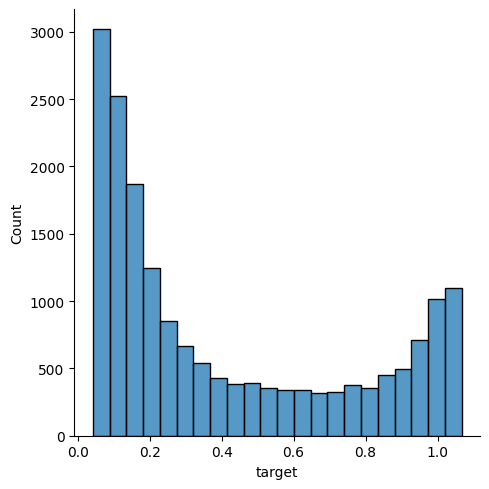

In [66]:
sns.displot(test_pairs.target)

In [67]:
test_id2pic = {line.variantid:line.main_pic_embeddings_resnet_v1[0] for line in test.itertuples()}
    
test["pic_embeddings_resnet_v1"] = test.pic_embeddings_resnet_v1.apply(
    lambda x: [] if x is None else [normalize(emb.reshape(-1, 1), axis=0).ravel() for emb in x]
)
test_id2pics = {
    line.variantid : normalize(np.mean(
        [
            normalize(line.main_pic_embeddings_resnet_v1[0].reshape(-1, 1), axis=0).ravel(), 
            *line.pic_embeddings_resnet_v1
        ], 
        axis=0
    ).reshape(-1, 1), axis=0).ravel()
    for line in test.itertuples()
}

In [68]:
pred = []
for line in test_pairs.itertuples():
    similarity = cosine_similarity(test_id2pic[line.variantid1].reshape(1, -1), test_id2pic[line.variantid2].reshape(1, -1))
    pred.append((similarity[0][0] + line.target) / 2)

In [69]:
submission2 = test_pairs.copy()
submission2.target = pred

In [70]:
submission2.to_csv('submission2.csv', index=False)

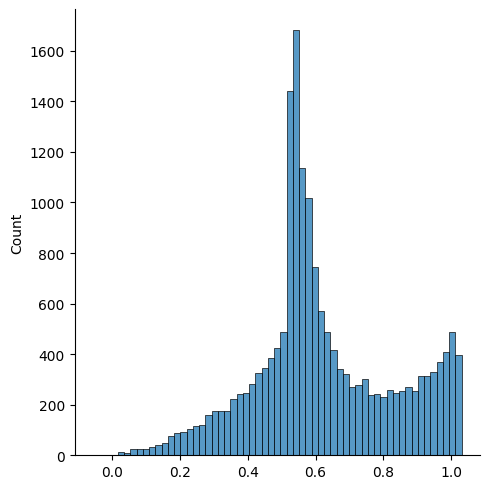

In [71]:
sns.displot(pred)

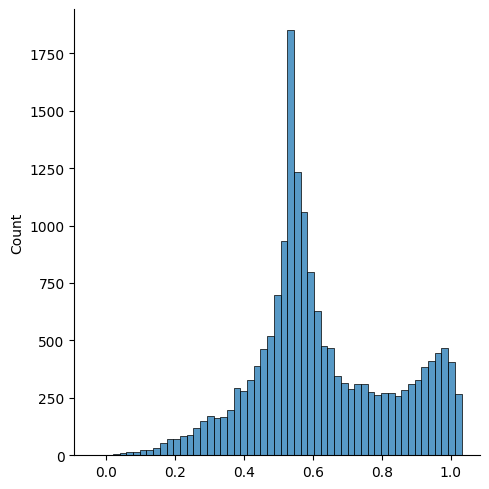

In [72]:
pred = []
for line in test_pairs.itertuples():
    similarity = cosine_similarity(test_id2pics[line.variantid1].reshape(1, -1), test_id2pics[line.variantid2].reshape(1, -1))
    pred.append(
        (similarity[0][0] + line.target) / 2
    )

submission3 = test_pairs.copy()
submission3.target = pred
submission3.to_csv('submission3.csv', index=False)

sns.displot(pred)